In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
import pandas as pd
import numpy as np
import random
import sc_toolbox

from scipy.sparse import csr_matrix, isspmatrix
from datetime import datetime

import rpy2.rinterface_lib.callbacks
import anndata2ri
import logging

from rpy2.robjects import pandas2ri
from rpy2.robjects import r

In [3]:
import sys
sys.path.append('..')

from src.configs import config
from src.utils import visualise as vs
from src.utils import utils as us
%load_ext autoreload
%autoreload 2

In [4]:
sc.settings.verbosity = 0
rpy2.rinterface_lib.callbacks.logger.setLevel(logging.ERROR)

pandas2ri.activate()
anndata2ri.activate()

%load_ext rpy2.ipython
warnings.filterwarnings("once")
warnings.filterwarnings("ignore", category=FutureWarning)

In [5]:
%%R
library(edgeR)
library(limma)
# install.packages("BiocManager") # Needed to install all Bioconductor packages
# BiocManager::install("testthat")
library(lme4)
library(MAST)

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/ipython/rmagic.py:984: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(


Loading required package: limma
Loading required package: Matrix
Loading required package: SingleCellExperiment
Loading required package: SummarizedExperiment
Loading required package: MatrixGenerics
Loading required package: matrixStats

Attaching package: ‘MatrixGenerics’

The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadD

# Load Data

In [6]:
print(datetime.now())
# adata = sc.read('/home/..../brainomics/Dati/1_AdataFilt.h5ad')
# adata = sc.read(config.PATHS.DATA/'2_AdataNorm.h5ad')
# adata = sc.read(config.PATHS.DATA/'1_AssembledAdata.h5ad')
adata = sc.read(config.PATHS.DATA/'1_AdataFilt.h5ad')

print(adata.shape)
print('isspmatrix:', isspmatrix(adata.X))


print('Loaded Filtered AnnData object: number of cells', adata.n_obs)
print('Loaded Filtered AnnData object: number of genes', adata.n_vars) 
print('Available metadata for each cell: ', adata.obs.columns)

2023-09-13 20:19:58.322942
(36034, 23454)
isspmatrix: True
Loaded Filtered AnnData object: number of cells 36034
Loaded Filtered AnnData object: number of genes 23454
Available metadata for each cell:  Index(['timepoint', 'line', '10X_date', 'clusters', 'tSNE_1', 'tSNE_2',
       'sample_id', 'run_id', 'cell_label', 'n_genes_by_counts',
       'total_counts', 'total_counts_mito', 'pct_counts_mito',
       'total_counts_ribo', 'pct_counts_ribo', 'QC_doublets'],
      dtype='object')


In [7]:
pd.crosstab(adata.obs['line'], adata.obs['timepoint'], margins=True)

timepoint,.d5,.w4,d5,d14,d35,d35b1,d35b2,d35b3,d35b4,w2,w4,w5,All
line,,,,,,,,,,,,,
409b2,814,1015,1015,0,0,0,0,0,0,1436,5924,2542,12746
bmrna,0,0,0,239,0,159,851,0,0,0,0,0,1249
h9,0,0,0,706,5482,0,0,0,0,0,0,1996,8184
joc,0,0,0,284,0,19,86,0,0,0,0,0,389
sandraA,0,709,1642,235,0,281,513,273,102,1857,368,2493,8473
sc102a1,0,0,0,963,3099,0,0,0,0,0,0,931,4993
All,814,1724,2657,2427,8581,459,1450,273,102,3293,6292,7962,36034


In [8]:
adata.obs['time'] = adata.obs.timepoint.apply(
    lambda x: 'd{}'.format(config.TIMEPOINT_MAP[x]))
adata.obs['replicate'] = adata.obs.timepoint.apply(
    lambda x: 'b{}'.format(config.BATCH_MAP[x]))
adata.obs['sample'] = \
    adata.obs.line.astype(str) + '_' + adata.obs.replicate + '_' + adata.obs.time

In [9]:
obs_to_keep = [
    "sample", "clusters", "replicate", "line", 
    "time", "isHuman", "isInduced"
]

In [10]:
# to pass the raw counts to edgeR .X is set 
# to the counts layer to ensure the pseudo-replicates
# are created for raw counts.
adata.layers['counts'] = adata.X.copy()
adata.X = adata.layers["counts"].copy()

In [11]:
adata.obs['isHuman'] = adata.obs.line.apply(
    lambda x: "h{}".format(x.lower() in config.HUMANS))

In [12]:
adata.X = adata.layers["counts"].copy()

sc.pp.normalize_total(adata, target_sum=1e6)
sc.pp.log1p(adata)

# Exclude Non-Human

In [13]:
idxs = np.prod([
    adata.obs.time.apply(lambda x: x in [ 'd14', 'd35' ]),
    # adata.obs.line.apply(lambda x: x.lower() in config.HUMANS),
], axis=0, dtype=np.bool_)
selected = adata[idxs, :].copy()
selected.obs

,timepoint,line,10X_date,clusters,tSNE_1,tSNE_2,sample_id,run_id,cell_label,n_genes_by_counts,total_counts,total_counts_mito,pct_counts_mito,total_counts_ribo,pct_counts_ribo,QC_doublets,time,replicate,sample,isHuman
AAACCTGAGTACTTGC-9.w2_409b2_171212,w2,409b2,171212,C5,45.486102,-28.756658,409b2,NoInfo,C5,2438,7036,170,2.416146,1754,24.928937,0.056589,d14,b1,409b2_b1_d14,hTrue
AAACCTGCACGGCCAT-9.w2_409b2_171212,w2,409b2,171212,C7,36.626131,6.664266,409b2,NoInfo,C7,2572,7492,174,2.322477,1743,23.264816,0.056589,d14,b1,409b2_b1_d14,hTrue
AAACCTGCAGTATCTG-9.w2_409b2_171212,w2,409b2,171212,C5,36.483634,-26.967325,409b2,NoInfo,C5,2439,6413,226,3.524092,1417,22.095743,0.035814,d14,b1,409b2_b1_d14,hTrue
AAACCTGGTTTAAGCC-9.w2_409b2_171212,w2,409b2,171212,C7,35.570214,34.445170,409b2,NoInfo,C7,2750,8043,334,4.152679,1858,23.100833,0.066282,d14,b1,409b2_b1_d14,hTrue
AAACGGGCACGCCAGT-9.w2_409b2_171212,w2,409b2,171212,C5,36.968570,-28.070171,409b2,NoInfo,C5,2132,5279,144,2.727789,1199,22.712635,0.030606,d14,b1,409b2_b1_d14,hTrue
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
TGTAAGCTCCATTTCA.1.d35b2_joc_200908,d35b2,joc,200908,C5,40.172446,-81.497956,joc,NoInfo,C5,1582,2916,26,0.891632,265,9.087791,0.065413,d35,b4,joc_b4_d35,hFalse
TTCCGGTTCAACTGGT.1.d35b2_joc_200908,d35b2,joc,200908,C7,49.852562,59.854382,joc,NoInfo,C7,3068,6301,55,0.872877,550,8.728773,0.073703,d35,b4,joc_b4_d35,hFalse
TTGCTGCAGCCTATTG.1.d35b2_joc_200908,d35b2,joc,200908,C7,37.487645,47.619635,joc,NoInfo,C7,3500,9039,116,1.283328,954,10.554265,0.068966,d35,b4,joc_b4_d35,hFalse
TTGTGGAAGATCACCT.1.d35b2_joc_200908,d35b2,joc,200908,C7,55.044737,5.588699,joc,NoInfo,C7,2744,6811,103,1.512260,807,11.848480,0.230038,d35,b4,joc_b4_d35,hFalse


# MAST

In [14]:
cell_type = "C5"
adata_mono = selected[selected.obs["clusters"] == cell_type].copy()
adata_mono

AnnData object with n_obs × n_vars = 3979 × 23454
    obs: 'timepoint', 'line', '10X_date', 'clusters', 'tSNE_1', 'tSNE_2', 'sample_id', 'run_id', 'cell_label', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'QC_doublets', 'time', 'replicate', 'sample', 'isHuman'
    var: 'mito', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts'
    uns: 'line_colors', 'log1p'
    layers: 'counts'

In [15]:
from anndata2ri import converter
import scipy


adata_mono.X = scipy.sparse.csc_matrix(adata_mono.X.astype(float))
adata_mono.layers['counts'] = scipy.sparse.csc_matrix(
    adata_mono.layers['counts'].astype(float))

# adata_mono.obs.lib_size = adata_mono.obs.lib_size.astype(float)
# adata_mono.obs.log_lib_size = adata_mono.obs.log_lib_size.astype(float)
adata_mono.obs.head()

,timepoint,line,10X_date,clusters,tSNE_1,tSNE_2,sample_id,run_id,cell_label,n_genes_by_counts,total_counts,total_counts_mito,pct_counts_mito,total_counts_ribo,pct_counts_ribo,QC_doublets,time,replicate,sample,isHuman
AAACCTGAGTACTTGC-9.w2_409b2_171212,w2,409b2,171212,C5,45.486102,-28.756658,409b2,NoInfo,C5,2438,7036,170,2.416146,1754,24.928937,0.056589,d14,b1,409b2_b1_d14,hTrue
AAACCTGCAGTATCTG-9.w2_409b2_171212,w2,409b2,171212,C5,36.483634,-26.967325,409b2,NoInfo,C5,2439,6413,226,3.524092,1417,22.095743,0.035814,d14,b1,409b2_b1_d14,hTrue
AAACGGGCACGCCAGT-9.w2_409b2_171212,w2,409b2,171212,C5,36.968570,-28.070171,409b2,NoInfo,C5,2132,5279,144,2.727789,1199,22.712635,0.030606,d14,b1,409b2_b1_d14,hTrue
AAAGTAGCACTTCGAA-9.w2_409b2_171212,w2,409b2,171212,C5,33.940925,-84.211375,409b2,NoInfo,C5,2158,5061,117,2.311796,745,14.720411,0.038388,d14,b1,409b2_b1_d14,hTrue
AAAGTAGGTACGCACC-9.w2_409b2_171212,w2,409b2,171212,C5,58.108841,-23.293718,409b2,NoInfo,C5,2914,7498,100,1.333689,1284,17.124567,0.095431,d14,b1,409b2_b1_d14,hTrue


In [16]:
sc.pp.filter_genes(adata_mono, min_cells=3)
adata_mono = us.prep_anndata(adata_mono)
adata_mono

AnnData object with n_obs × n_vars = 3979 × 18731
    obs: 'timepoint', 'line', '10X_date', 'clusters', 'tSNE_1', 'tSNE_2', 'sample_id', 'run_id', 'cell_label', 'n_genes_by_counts', 'total_counts', 'total_counts_mito', 'pct_counts_mito', 'total_counts_ribo', 'pct_counts_ribo', 'QC_doublets', 'time', 'replicate', 'sample', 'isHuman'
    var: 'n_cells'

In [41]:
%%R
find_de_MAST_RE <- function(adata_){
    # create a MAST object
    sca <- SceToSingleCellAssay(adata_, class = "SingleCellAssay")
    print("Dimensions before subsetting:")
    print(dim(sca))
    print("")

    # keep genes that are expressed in more than 10% of all cells
    sca <- sca[freq(sca) > 0.1, ]
    print("Dimensions after subsetting:")
    print(dim(sca))
    print("")

    # add a column to the data which contains scaled number of genes that are expressed in each cell
    cdr2 <- colSums(assay(sca) > 0)
    colData(sca)$ngeneson <- scale(cdr2)
    # store the columns that we are interested in as factors
    label <- factor(colData(sca)$time)
    # set the reference level
    #label <- relevel(label, "d14")
    colData(sca)$label <- label
    # celltype <- factor(colData(sca)$clusters)
    # colData(sca)$celltype <- celltype
    # isHuman <- factor(colData(sca)$isHuman)
    # colData(sca)$isHuman <- isHuman

    # same for donors (which we need to model random effects)
    replicate <- factor(colData(sca)$isHuman)
    colData(sca)$replicate <- replicate

    # create a group per condition-celltype combination
    # colData(sca)$group <- paste0(colData(adata_)$label, ".", colData(adata_)$celltype)
    # colData(sca)$group <- factor(colData(sca)$group)

    # define and fit the model
    zlmCond <- zlm(formula = ~0 + ngeneson + label + (1 | replicate), 
                   sca=sca, 
                   method='glmer', 
                   ebayes=F, 
                   strictConvergence=F,
                   fitArgsD=list(nAGQ = 0)) # to speed up calculations
    return(zlmCond)
    # perform likelihood-ratio test for the condition that we are interested in    
#     summaryCond <- summary(zlmCond, doLRT='groupd35')
#     # get the table with log-fold changes and p-values
#     summaryDt <- summaryCond$datatable
    # result <- merge(summaryDt[contrast=='groupd35.C5' & component=='H',.(primerid, `Pr(>Chisq)`)], # p-values
    #                  summaryDt[contrast=='groupd35.C5' & component=='logFC', .(primerid, coef)],
    #                  by='primerid') # logFC coefficients
    
#     # MAST uses natural logarithm so we convert the coefficients to log2 base to be comparable to edgeR
#     result[,coef:=result[,coef]/log(2)]
#     # do multiple testing correction
#     result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
#     result = result[result$FDR<0.01,, drop=F]

#     result <- stats::na.omit(as.data.frame(result))
#     return(result)
}

In [42]:
%%time
%%R -i adata_mono -o res
res <-find_de_MAST_RE(adata_mono)

/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(


[1] "Dimensions before subsetting:"
[1] 18731  3979
[1] ""
[1] "Dimensions after subsetting:"
[1] 7201 3979
[1] ""


/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/ipython/rmagic.py:984: DeprecationWarning: The `source` parameter emit a  deprecation warning since IPython 8.0, it had no effects for a long time and will  be removed in future versions.
  displaypub.publish_display_data(


`fData` has no primerid.  I'll make something up.
`cData` has no wellKey.  I'll make something up.
Assuming data assay in position 1, with name X is log-transformed.
Error : grouping factors must have > 1 sampled level
Error : grouping factors must have > 1 sampled level
Error : grouping factors must have > 1 sampled level

Done!


CPU times: user 10min 40s, sys: 4.8 s, total: 10min 45s
Wall time: 10min 45s


In [44]:
%%R -o result
summaryCond <- summary(res, doLRT='labeld35-labeld14')
# get the table with log-fold changes and p-values
summaryDt <- summaryCond$datatable
result <- merge(summaryDt[contrast=='labeld35-labeld14' & component=='H',.(primerid, `Pr(>Chisq)`)], # p-values
                 summaryDt[contrast=='labeld35-labeld14' & component=='logFC', .(primerid, coef)],
                 by='primerid') # logFC coefficients

# MAST uses natural logarithm so we convert the coefficients to log2 base to be comparable to edgeR
result[,coef:=result[,coef]/log(2)]
# do multiple testing correction
result[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]
result = result[result$FDR<0.01,, drop=F]
result <- stats::na.omit(as.data.frame(result))

Combining coefficients and standard errors
Calculating log-fold changes
Calculating likelihood ratio tests
Error in generateHypothesis(hypothesis, colnames(object@coefD)) : 
  Term(s) 'labeld35-labeld14 ,' not found.
Terms available: (Intercept) , ngeneson , labeld35 ,


RInterpreterError: Failed to parse and evaluate line "summaryCond <- summary(res, doLRT='labeld35-labeld14')\n# get the table with log-fold changes and p-values\nsummaryDt <- summaryCond$datatable\nresult <- merge(summaryDt[contrast=='labeld35-labeld14' & component=='H',.(primerid, `Pr(>Chisq)`)], # p-values\n                 summaryDt[contrast=='labeld35-labeld14' & component=='logFC', .(primerid, coef)],\n                 by='primerid') # logFC coefficients\n\n# MAST uses natural logarithm so we convert the coefficients to log2 base to be comparable to edgeR\nresult[,coef:=result[,coef]/log(2)]\n# do multiple testing correction\nresult[,FDR:=p.adjust(`Pr(>Chisq)`, 'fdr')]\nresult = result[result$FDR<0.01,, drop=F]\nresult <- stats::na.omit(as.data.frame(result))\n".
R error message: "Error in generateHypothesis(hypothesis, colnames(object@coefD)) : \n  Term(s) 'labeld35-labeld14 ,' not found.\nTerms available: (Intercept) , ngeneson , labeld35 ,"
R stdout:
Combining coefficients and standard errors
Calculating log-fold changes
Calculating likelihood ratio tests
Error in generateHypothesis(hypothesis, colnames(object@coefD)) : 
  Term(s) 'labeld35-labeld14 ,' not found.
Terms available: (Intercept) , ngeneson , labeld35 ,

In [32]:
res.sort_values('FDR')

,primerid,Pr(>Chisq),coef,FDR
3147,SCG2,1.375037e-268,4.776856,9.901640e-265
1465,H3F3A,9.707507e-256,-0.936013,3.495188e-252
4004,VGF,1.504082e-252,3.215974,3.610297e-249
1918,MAP1LC3A,7.004734e-199,2.522563,1.261027e-195
2778,PTMS,4.670879e-171,-1.017682,6.727000e-168
...,...,...,...,...
568,CCDC64,5.772043e-03,0.171310,9.915191e-03
1914,MANEAL,5.801314e-03,0.305437,9.963097e-03
278,ATP5O,5.810012e-03,0.131993,9.975655e-03
2421,OGFR,5.815464e-03,0.236093,9.980256e-03


In [41]:
%%time
%%R -i adata_mono --converter anndata2ri.converter
outs <- fit_model(adata_mono)

[1] "Dimensions before subsetting:"
[1] 23454    80
[1] ""
[1] "Dimensions after subsetting:"
[1] 13129    80
[1] ""


/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/robjects/pandas2ri.py:368: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/robjects/numpy2ri.py:241: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  warnings.warn('The global conversion available with activate() '
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28: DeprecationWarning: The use of converter in module rpy2.robjects.conversion is deprecated. Use rpy2.robjects.conversion.get_conversion() instead of rpy2.robjects.conversion.converter.
  warnings.warn(
/home/vess/Distr/conda/envs/HT/lib/python3.9/site-packages/rpy2/robjects/conversion.py:28

CPU times: user 6.15 s, sys: 133 ms, total: 6.29 s
Wall time: 6.28 s


In [42]:
%%R
fit <- outs$fit
y <- outs$y

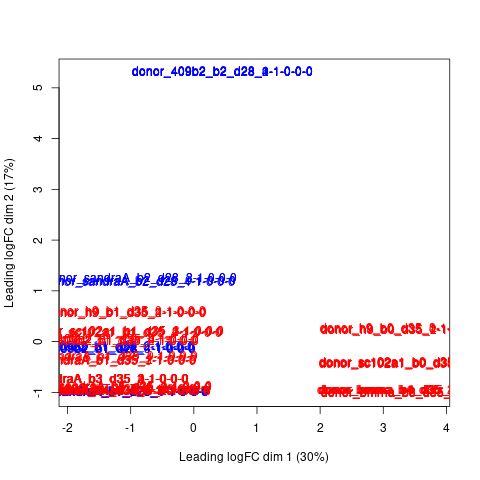

In [43]:
%%R
plotMDS(y, col=ifelse(y$samples$group == "d35", "red", "blue"))

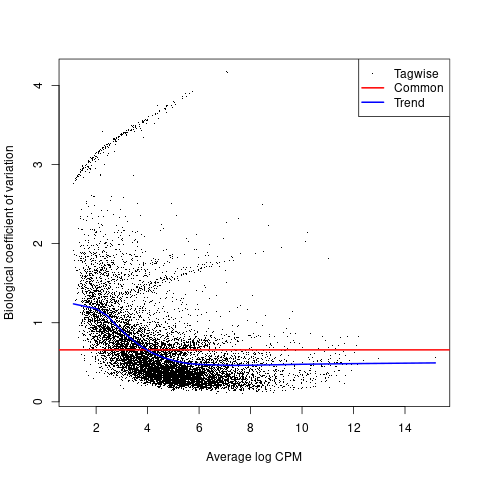

In [44]:
%%R
plotBCV(y)

In [45]:
%%R
colnames(y$design)

[1] "groupd28.hFalse" "groupd28.hTrue"  "groupd35.hFalse" "groupd35.hTrue" 


In [51]:
%%R -o tt
contrasts <- makeContrasts(
    # X_T2vsT1="groupd35.hFalse-groupd28.hFalse",
    # Y_T2vsT1="groupd35.hTrue-groupd28.hTrue",
    XvsY="(groupd35.hTrue-groupd28.hTrue)-(groupd35.hFalse-groupd28.hFalse)",
    levels=y$design)
qlf <- glmQLFTest(fit, contrast=contrasts)
# get all of the DE genes and calculate Benjamini-Hochberg adjusted FDR
tt <- topTags(qlf, n = Inf)
tt <- tt$table
contrasts

                 Contrasts
Levels            XvsY
  groupd28.hFalse    1
  groupd28.hTrue    -1
  groupd35.hFalse   -1
  groupd35.hTrue     1


In [52]:
tt.shape
tt[:5]

,logFC,logCPM,F,PValue,FDR
CPNE9,-8.050183,2.664854,260.084503,2.224568e-25,2.920635e-21
ARRB1,-8.268321,2.608351,189.159786,1.163903e-21,7.640441e-18
LINC01122,-6.880992,2.618234,180.871192,3.680164e-21,1.610562e-17
SH2B3,-7.305492,2.163297,153.794962,2.104395e-19,6.419211e-16
ZNF846,-6.892662,2.131622,152.850496,2.444669e-19,6.419211e-16


In [53]:
%%R
tr <- glmTreat(fit, contrast=contrasts, lfc=1.5)
print(head(topTags(tr)))

Coefficient:  1*groupd28.hFalse -1*groupd28.hTrue -1*groupd35.hFalse 1*groupd35.hTrue 
           logFC unshrunk.logFC   logCPM       PValue          FDR
CPNE9  -8.050183     -144269488 2.664854 5.385688e-22 7.070869e-18
ARRB1  -8.268321     -144269488 2.608351 8.320196e-19 5.461792e-15
SH2B3  -7.305492     -144269487 2.163297 1.989376e-16 8.706172e-13
CBWD5  -7.528353     -144269487 3.979209 3.092313e-15 1.014974e-11
POLR3B -7.606589     -144269487 3.023595 7.728011e-15 1.695162e-11
HCST   -7.085457     -144269487 2.352039 7.746950e-15 1.695162e-11


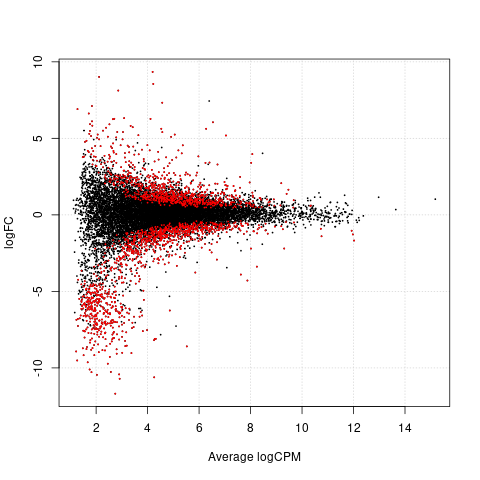

In [54]:
%%R
plotSmear(qlf, de.tags = rownames(tt)[which(tt$FDR< .01)])

In [55]:
tt["gene_symbol"] = tt.index
tt["clusters"] = cell_type
sc_toolbox.tools.de_res_to_anndata(
    selected,
    tt,
    groupby="clusters",
    score_col="logCPM",
    pval_col="PValue",
    pval_adj_col="FDR",
    lfc_col="logFC",
    key_added="edgeR_" + cell_type,
)
tt.to_csv(f"de_edgeR_{cell_type}.csv")

# Visualise

In [56]:
selected.X = selected.layers["counts"].copy()
sc.pp.normalize_total(selected, target_sum=1e6)
sc.pp.log1p(selected)

In [77]:
FDR = 0.001
LOG_FOLD_CHANGE = 5.


def plot_heatmap(adata, group_key, group_name="clusters", groupby="time"):
    cell_type = "_".join(group_key.split("_")[1:])
    res = sc.get.rank_genes_groups_df(adata, group=cell_type, key=group_key)
    res.index = res["names"].values
    res = res[
        (res["pvals_adj"] < FDR) & (abs(res["logfoldchanges"]) > LOG_FOLD_CHANGE)
    ].sort_values(by=["logfoldchanges"])
    print(f"Plotting {len(res)} genes...")
    markers = list(res.index)
    sc.pl.heatmap(
        adata[adata.obs[group_name] == cell_type].copy(),
        markers,
        groupby=groupby,
        swap_axes=True,
    )


Plotting 31 genes...


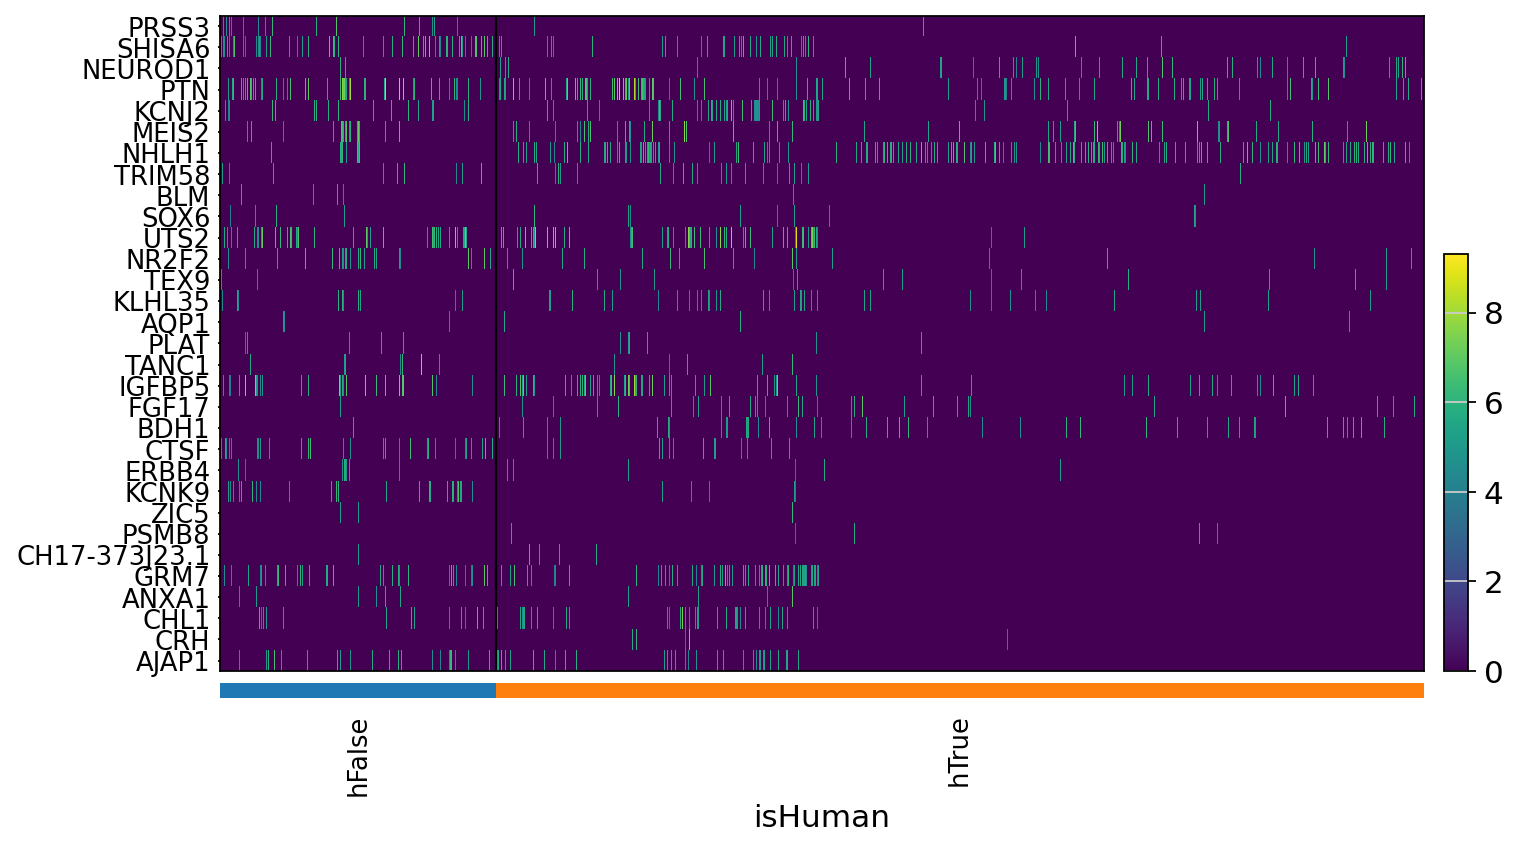

In [78]:
group_key = "edgeR_C5"
adata = selected
group_name="clusters"
groupby="isHuman"

cell_type = "_".join(group_key.split("_")[1:])
res = sc.get.rank_genes_groups_df(adata, group=cell_type, key=group_key)
res.index = res["names"].values
res = res[
    (res["pvals_adj"] < FDR) & ((res["logfoldchanges"]) > LOG_FOLD_CHANGE)
].sort_values(by=["logfoldchanges"])
print(f"Plotting {len(res)} genes...")
markers = list(res.index)
sc.pl.heatmap(
    adata[adata.obs[group_name] == cell_type].copy(),
    markers,
    groupby=groupby,
    swap_axes=True,
)


Plotting 267 genes...


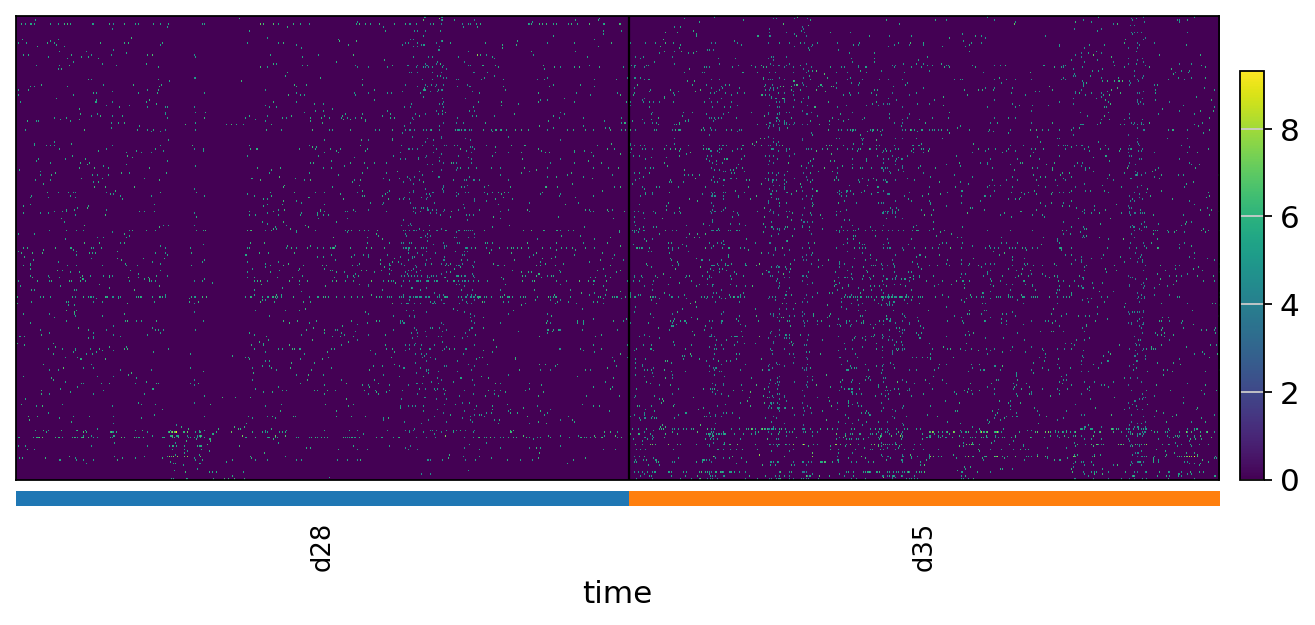

In [79]:
plot_heatmap(selected, "edgeR_C5")

In [80]:
LOG_FOLD_CHANGE = 3.


def volcano_plot(adata, group_key, group_name="clusters", groupby="time", title=None):
    cell_type = "_".join(group_key.split("_")[1:])
    result = sc.get.rank_genes_groups_df(adata, group=cell_type, key=group_key).copy()
    result["-logQ"] = -np.log(result["pvals"].astype("float"))
    lowqval_de = result.loc[abs(result["logfoldchanges"]) > LOG_FOLD_CHANGE]
    other_de = result.loc[abs(result["logfoldchanges"]) <= LOG_FOLD_CHANGE]

    fig, ax = plt.subplots(figsize=(10, 10))
    sns.regplot(
        x=other_de["logfoldchanges"],
        y=other_de["-logQ"],
        fit_reg=False,
        scatter_kws={"s": 6},
    )
    sns.regplot(
        x=lowqval_de["logfoldchanges"],
        y=lowqval_de["-logQ"],
        fit_reg=False,
        scatter_kws={"s": 6},
    )
    ax.set_xlabel("log2 FC")
    ax.set_ylabel("-log Q-value")

    if title is None:
        title = group_key.replace("_", " ")
    plt.title(title)
    plt.show()

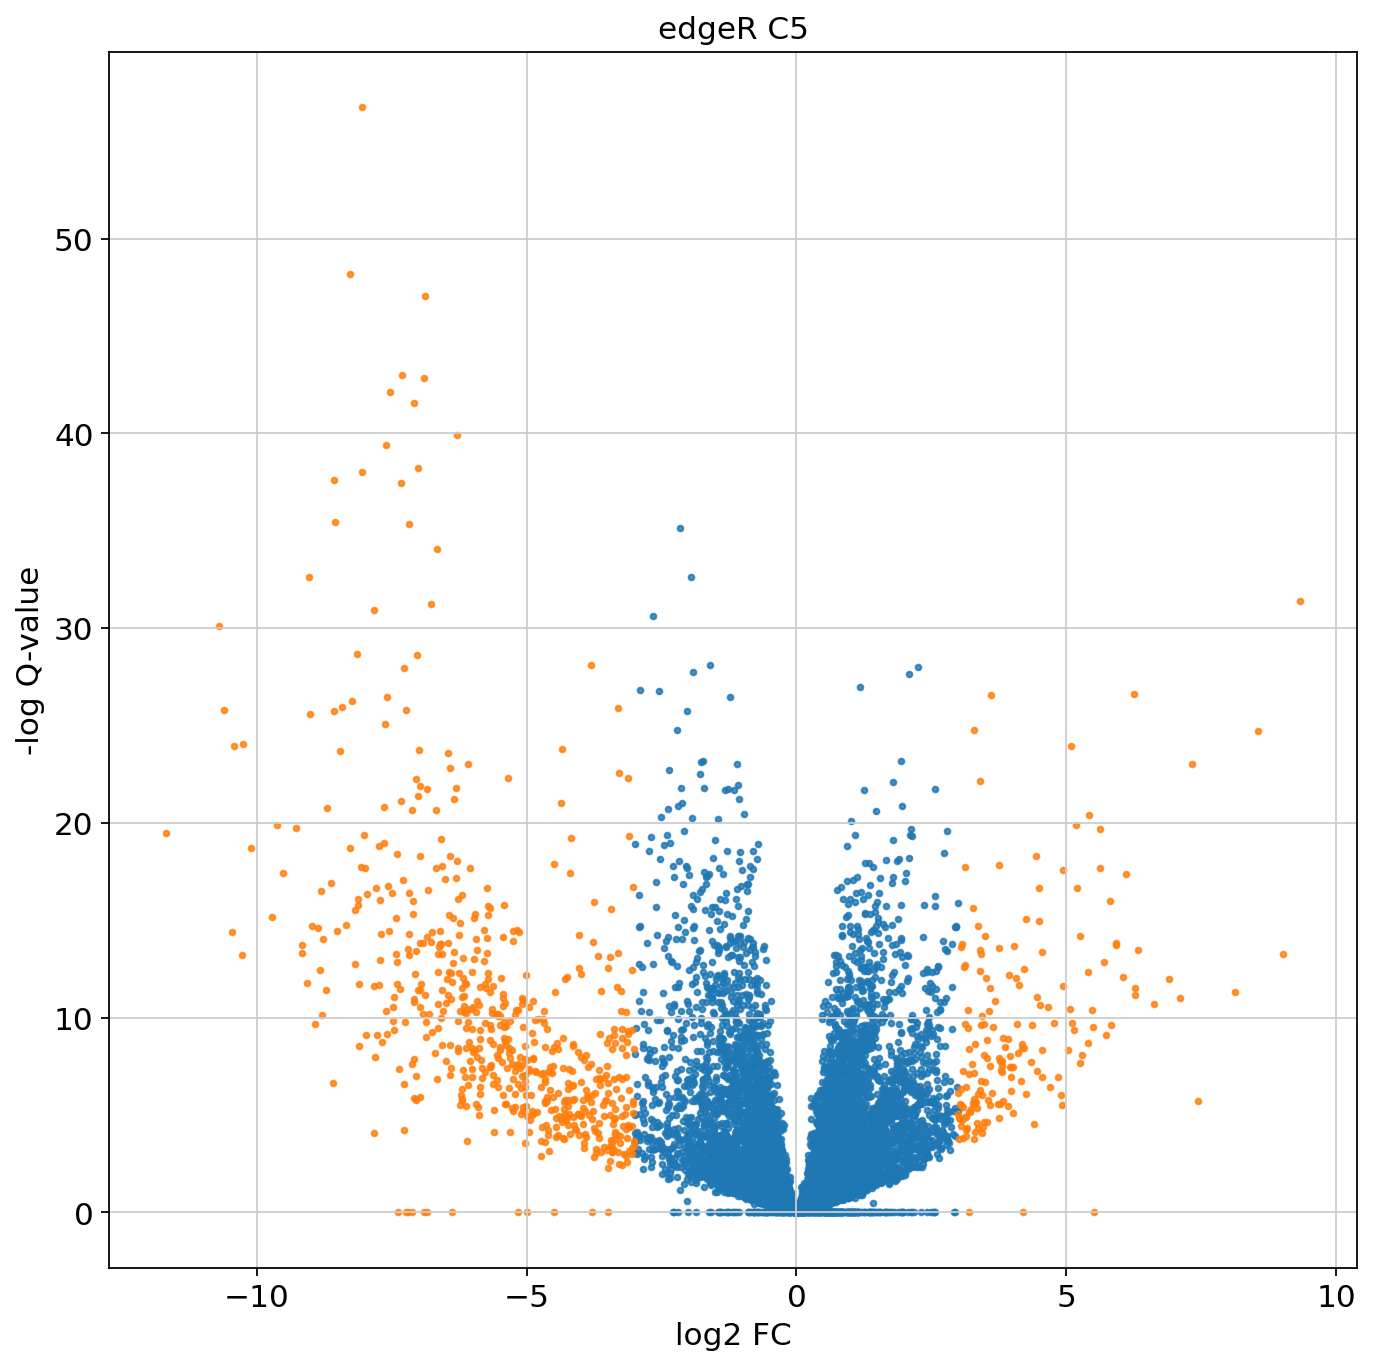

In [81]:
volcano_plot(selected, "edgeR_C5")